**Scope:**  
Check whether longer incubation of primary antibody leads to stronger signals. Build classes to handle images and cell objects.

Plate design:  
https://docs.google.com/spreadsheets/d/1X6NSBpaULj6qFl_G7HlqtHokv0nRJk4Wsy7u1vs9jf0/edit#gid=0

In [1]:
from os.path import join
import numpy as np
from scipy.ndimage import imread
import matplotlib.pyplot as plt
from collections import OrderedDict
from glob import glob
from mi_align import MutualInfoAlignerMultiHypothesis as miamh
import json
import tifffile as tiff
from segmentation_operations import lapgauss_constant
from skimage.measure import regionprops
from segmentation_operations import constant_lap_edge
from datamodel import Field, ImageDict

%matplotlib inline

### Load images, crop and save

Load a weight matrix for linear unmixing and background references.

In [2]:
import tempfile
import urllib
temp_dir= tempfile.mkdtemp()
urllib.urlretrieve('http://archive.simtk.org/ktrprotocol/temp/lu_weight.npy', join(temp_dir, 'lu_weight.npy'))
weight = np.load(join(temp_dir, 'lu_weight.npy'))
urllib.urlretrieve('http://archive.simtk.org/ktrprotocol/temp/bg_hela.npy', join(temp_dir, 'bg_hela.npy'))
bg_hela = np.load(join(temp_dir, 'bg_hela.npy'))

In [3]:
from datamodel import unmixing
patterns = ['*channel006*', '*channel007*', '*channel000*', '*channel001*', '*channel008*', '*channel003*', '*channel004*', '*channel005*']
colors = ['AMCA', 'DAPI', 'CFP', 'FITC', 'Orange', 'TRITC', 'Cherry', 'Farred']

In [4]:
parent_dir0 = "/Volumes/covert-lab/instruments/covert-lab-scope1/scope1dataM/Taka/20170123eTK078/beforestain_1/"
parent_dir = "/Volumes/covert-lab/instruments/covert-lab-scope1/scope1dataM/Taka/20170123eTK078/run_1"

preif = Field(join(parent_dir0, 'B5_Site_1'), patterns, colors).construct()
postif = Field(join(parent_dir, 'B5_Site_1'), patterns, colors).construct()
bg_h = ImageDict()
for num, c in enumerate(colors):
    bg_h[c] = bg_hela[:, :, num]
print type(preif), type(postif), type(bg_h)
print preif.keys()
print postif.keys()
print bg_h.keys()

<class 'datamodel.ImageDict'> <class 'datamodel.ImageDict'> <class 'datamodel.ImageDict'>
['AMCA', 'DAPI', 'CFP', 'FITC', 'Orange', 'TRITC', 'Cherry', 'Farred']
['AMCA', 'DAPI', 'CFP', 'FITC', 'Orange', 'TRITC', 'Cherry', 'Farred']
['AMCA', 'DAPI', 'CFP', 'FITC', 'Orange', 'TRITC', 'Cherry', 'Farred']


preif, postif and bg_h are all ImageDict instances. They have a set of 8 images taken at different filter setting.  
preif contains Hoechst stained image so I will segment nuclei based on this image.

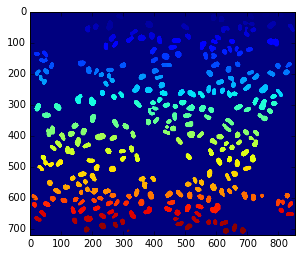

In [5]:
nuc = constant_lap_edge(preif['AMCA'], None, THRES=200, NUCRAD=15)
plt.imshow(nuc)

Implement background subtraction and linear unmixing

In [6]:
postif = postif - bg_h
corr_postif = unmixing(postif, weight)
preif = preif - bg_h
corr_preif = unmixing(preif, weight)

In [7]:
# Stack preif and postif
corr_preif.stack(corr_postif)

Align preif and postif and crop them. A segmented image is also cropped.

In [8]:
from datamodel import ImagesCropperNuc
icn = ImagesCropperNuc(corr_preif, nuc, DOWNSAMPLE=(4, 2))
# icn.calc_jitters()
icn.jitters = [(0, 0), (0, 0), (11, 8)]  # calculated beforehand
cropped, crop_nuc = icn.crop()

In [9]:
# segmented image to cropped ImageDict
cropped['nuc'] = crop_nuc

In [10]:
cropped.save('test.tif')

Now you can check all the images including segmented nuclei are saved as a single tiff stack file, 'test.tif'.  
Channel keys can be retrieved if you use ImageDict().load to read this image.

In [11]:
a = ImageDict()
a.load('test.tif')
print a.keys()

[u'AMCA', u'DAPI', u'CFP', u'FITC', u'Orange', u'TRITC', u'Cherry', u'Farred', u'nuc']


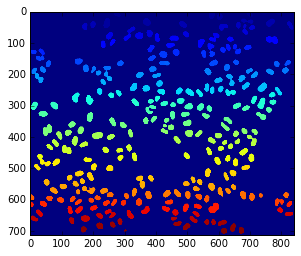

In [12]:
plt.imshow(a['nuc'])

Now repeat all the processes for multiple positions.

In [13]:
folders = []
for al in ('A', 'B', 'C','D','E', 'F', 'G'):
    for s in (4, 5, 6, 7):
        for s2 in (0, 1, 2, 3):
            folders.append('{0}{1}_Site_{2}'.format(al, s, s2))

In [46]:
# This part takes a while..

for folder in folders:
    preif = Field(join(parent_dir0, folder), patterns, colors).construct()
    postif = Field(join(parent_dir, folder), patterns, colors).construct()
    bg_h = ImageDict()
    for num, c in enumerate(colors):
        bg_h[c] = bg_hela[:, :, num]
    nuc = constant_lap_edge(preif['AMCA'], None, THRES=200, NUCRAD=15)
    postif = postif - bg_h
    corr_postif = unmixing(postif, weight)
    preif = preif - bg_h
    corr_preif = unmixing(preif, weight)
    corr_preif.stack(corr_postif)
    icn = ImagesCropperNuc(corr_preif, nuc, DOWNSAMPLE=(4, 2))
    icn.jitters = [(0, 0), (0, 0), (11, 8)]  # calculated beforehand. means [0, 0] pixels jitters for nuclear images, [0, 0] for hoechst stained and [11, 8] for postif.
    cropped, crop_nuc = icn.crop()
    cropped['nuc'] = crop_nuc
    cropped.save(join('/Volumes/covert-lab/share/Taka/2017/eTK078/images/', folder))
    print folder

G6_Site_0
G6_Site_1
G6_Site_2
G6_Site_3
G7_Site_0
G7_Site_1
G7_Site_2
G7_Site_3


Quickly check the nuclear segmentation.

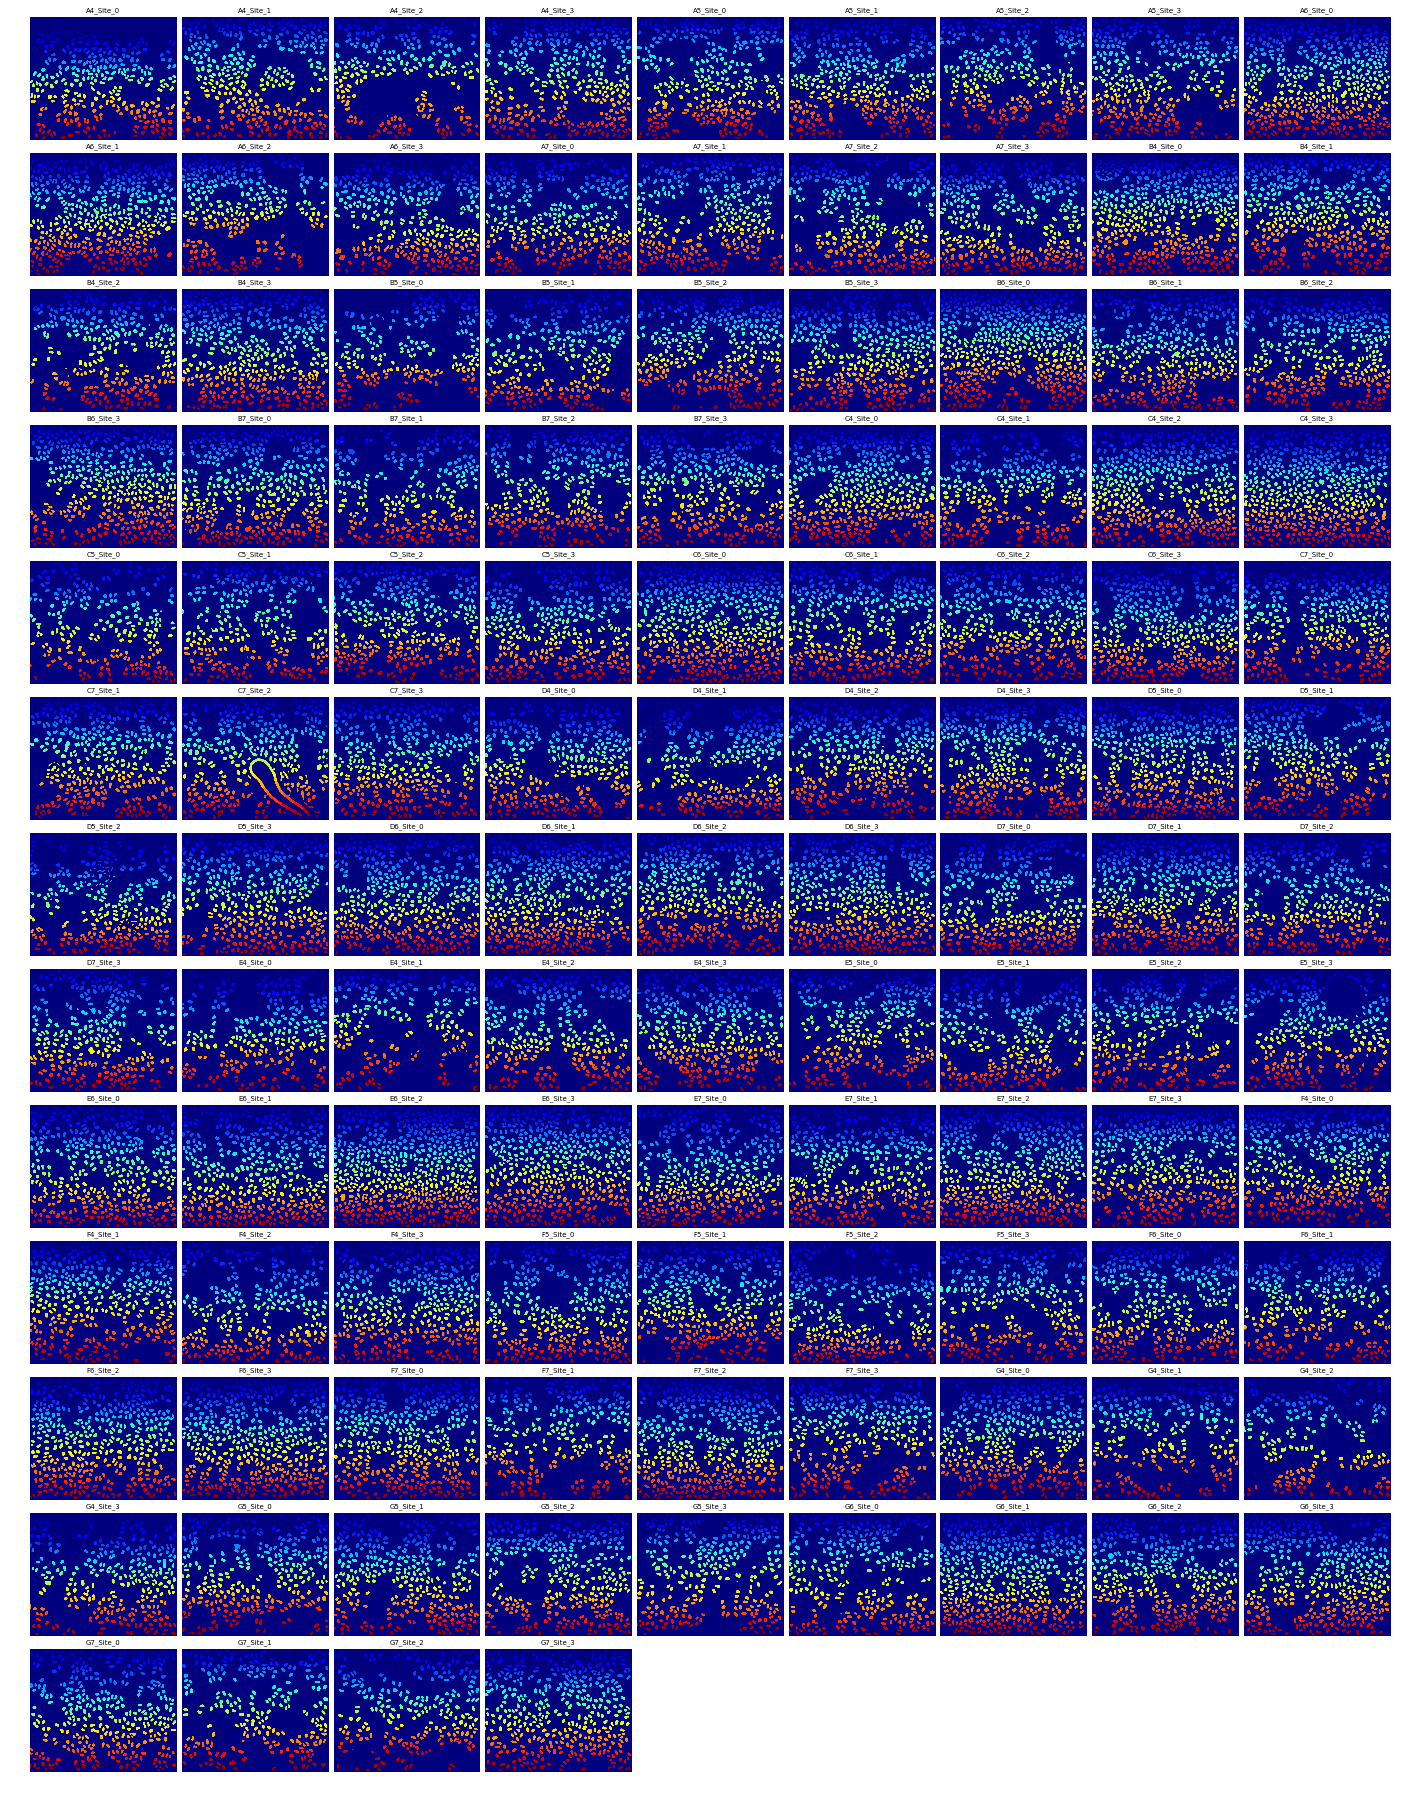

In [48]:
fig, axes = plt.subplots(13, 9, figsize=(20, 25))
axes = axes.flatten()
[ax.axis('off') for ax in axes]
for ax, folder in zip(axes, folders):
    im = ImageDict()
    im.load(join('/Volumes/covert-lab/share/Taka/2017/eTK078/images/', folder+'.tif'))
    ax.imshow(im['nuc'])
    ax.set_title(folder, fontsize=7)
plt.tight_layout(w_pad=-5, h_pad=-1)

C7_Site_2 contains a long objects. Other than it looks okay by a quick look.